In [3]:
import tensorflow as tf
from sklearn.datasets import load_sample_image
import numpy as np
import matplotlib.pyplot as plt

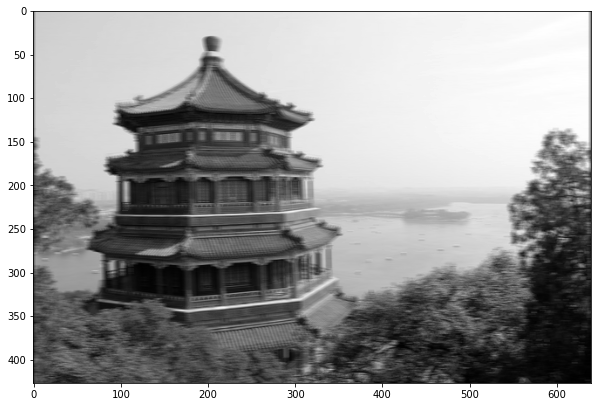

In [4]:
china = load_sample_image("china.jpg") / 255
flower = load_sample_image("flower.jpg") / 255
images = np.array([china, flower])
batch_size, height, width, channels = images.shape

filters = np.zeros(shape=(7, 7, channels, 2), dtype=np.float32)
filters[:, 3, :, 0] = 1 # vertical line
filters[3, :, :, 1] = 1

outputs = tf.nn.conv2d(images, filters, strides=1, padding="SAME")
plt.figure(figsize=(10, 7))
plt.imshow(outputs[0, :, :, 1], cmap="gray")
plt.show()

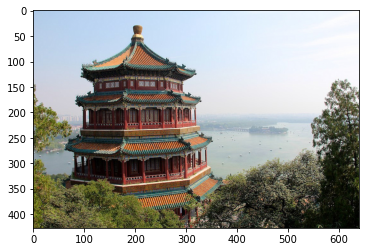

In [9]:
plt.imshow(china)

In [10]:
conv = tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides=1, 
                              padding="same", activation="relu")

In [2]:
max_pool = tf.keras.layers.MaxPool2D(pool_size=2)
avg_pool = tf.keras.layers.AvgPool2D(pool_size=2)

In [16]:
# depthwise Max Pooling
output = tf.nn.max_pool(images, 
                        ksize=(1, 1, 1, 3), 
                        strides=(1, 1, 1, 3), 
                        padding="VALID")

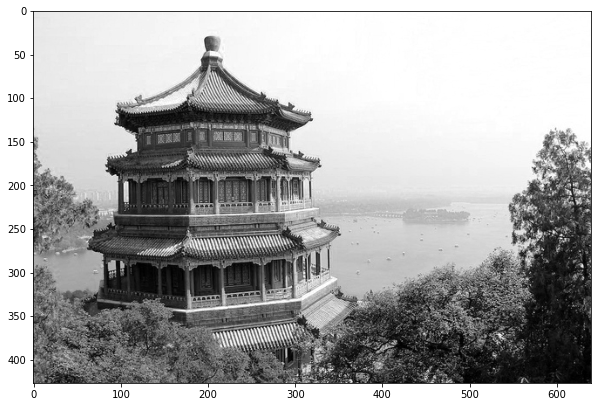

In [17]:
plt.figure(figsize=(10, 7))
plt.imshow(output[0, :, :, :], cmap="gray")
plt.show()

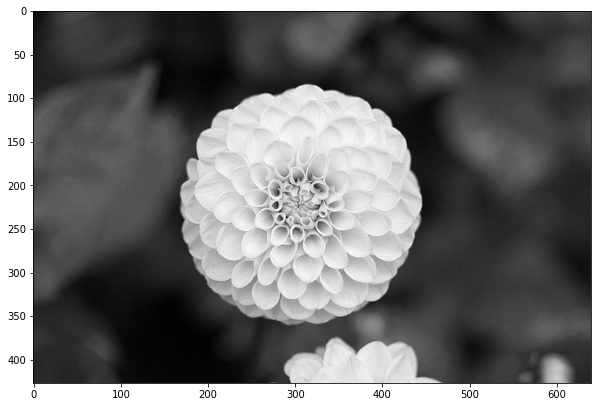

In [18]:
plt.figure(figsize=(10, 7))
plt.imshow(output[1, :, :, :], cmap="gray")
plt.show()

In [13]:
depth_max_pool = tf.keras.layers.Lambda(lambda x: tf.nn.max_pool(x, 
                                                                 ksize=(1, 1, 1, 3), 
                                                                 strides=(1, 1, 1, 3), 
                                                                 padding="VALID"))

In [ ]:
## Fashion Mnist
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, activations, Sequential



### ResNet-34

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, activations, Sequential
import numpy as np

In [8]:
from functools import partial

DefaultConv2D = partial(layers.Conv2D, kernel_size=3, strides=1, 
                        padding="SAME", use_bias=False)

class ResidualUnit(layers.Layer):
    def __init__(self, filters, strides=1, activation="relu", **kwargs):
        super().__init__(**kwargs)
        self.activation = activations.get(activation)
        self.main_layers = [
            DefaultConv2D(filters, strides=strides), 
            layers.BatchNormalization(), 
            self.activation, 
            DefaultConv2D(filters), 
            layers.BatchNormalization()
        ]
        self.skip_layers = []
        if strides > 1:
            self.skip_layers = [
                DefaultConv2D(filters, kernel_size=1, 
                              strides=strides), 
                layers.BatchNormalization()
            ]
    
    def call(self, inputs):
        Z = inputs
        for layer in self.main_layers:
            Z = layer(Z)
        skip_Z = inputs
        for layer in self.skip_layers:
            skip_Z = layer(skip_Z)
        return self.activation(Z + skip_Z)


In [9]:
model = Sequential()
model.add(DefaultConv2D(64, kernel_size=7, strides=2,
                        input_shape=[224, 224, 3]))
model.add(layers.BatchNormalization())
model.add(layers.Activation("relu"))
model.add(layers.MaxPool2D(pool_size=3, strides=2, padding="same"))
prev_filters = 64
for filters in [64] * 3 + [128] * 4 + [256] * 6 + [512] * 3:
    strides = 1 if filters == prev_filters else 2
    model.add(ResidualUnit(filters, strides=strides))
    prev_filters = filters
model.add(layers.GlobalAvgPool2D())
model.add(layers.Flatten())
model.add(layers.Dense(10, activation="softmax"))

In [10]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_13 (Conv2D)          (None, 112, 112, 64)      9408      
                                                                 
 batch_normalization_13 (Bat  (None, 112, 112, 64)     256       
 chNormalization)                                                
                                                                 
 activation_1 (Activation)   (None, 112, 112, 64)      0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                             
                                                                 
 residual_unit_4 (ResidualUn  (None, 56, 56, 64)       74240     
 it)                                                             
                                                      

In [11]:
(X_train, y_train), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train, X_val = X_train[:50000], X_train[50000:]
y_train, y_val = y_train[:50000], y_train[50000:]

In [13]:
model.compile(loss="sparse_categorical_crossentropy", 
              optimizer="adam", 
              metrics=["accuracy"])

### Using Pretrained networks

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, activations, Sequential
import numpy as np

In [2]:
model = keras.applications.resnet50.ResNet50(weights="imagenet")

102981632/102967424 [==============================] - 16s 0us/step


In [5]:
images_resized = tf.image.resize(images, [224, 224])

In [10]:
inputs = keras.applications.resnet50.preprocess_input(images_resized * 255)

In [11]:
y_probas = model.predict(inputs)

In [14]:
tf.argmax(y_probas, axis=1)

<tf.Tensor: shape=(2,), dtype=int64, numpy=array([442, 599], dtype=int64)>

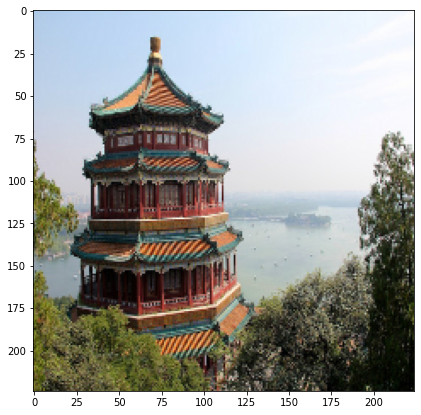

In [19]:
plt.figure(figsize=(10, 7))
plt.imshow(images_resized[0, :, :, :], cmap="gray")
plt.show()

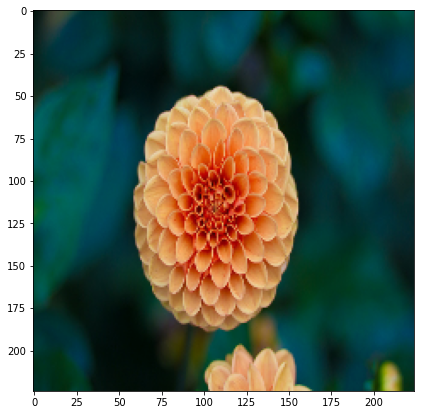

In [20]:
plt.figure(figsize=(10, 7))
plt.imshow(images_resized[1, :, :, :], cmap="gray")
plt.show()

In [22]:
top_K = keras.applications.resnet50.decode_predictions(y_probas, top=5)
for image_index in range(len(images)):
    print("Image #{}".format(image_index))
    for class_id, name, y_proba in top_K[image_index]:
        print("\t{} - {:12s} {:.2f}%".format(class_id, name, y_proba*100))
    print()

Image #0
	n02825657 - bell_cote    82.35%
	n03877845 - palace       6.75%
	n03781244 - monastery    4.19%
	n02980441 - castle       3.16%
	n03028079 - church       1.00%

Image #1
	n03530642 - honeycomb    49.81%
	n13040303 - stinkhorn    33.96%
	n02206856 - bee          4.35%
	n11939491 - daisy        3.23%
	n12985857 - coral_fungus 2.66%



### Using Pretrained Network for Transfer Learning

In [30]:
import tensorflow_datasets as tfds

dataset, info = tfds.load("tf_flowers", as_supervised=True, with_info=True)
dataset_size = info.splits["train"].num_examples
class_names = info.features["label"].names
n_classes = info.features["label"].num_classes
print("Dataset-Samples = {}\nNo. of Classes = {}".format(dataset_size, n_classes))

Dataset-Samples = 3670
No. of Classes = 5


In [41]:
train_set, val_set, test_set = tfds.load("tf_flowers", 
                                         split=['train[:75%]', 'train[75%:90%]', 'train[90%:]'], 
                                         as_supervised=True)

In [42]:
def preprocess(image, label):
    resized_image = tf.image.resize(image, [224, 224])
    final_image = keras.applications.xception.preprocess_input(resized_image)
    return final_image, label

In [43]:
batch_size = 32
train_set = train_set.map(preprocess).batch(batch_size).prefetch(tf.data.AUTOTUNE)
val_set = val_set.map(preprocess).batch(batch_size).prefetch(tf.data.AUTOTUNE)
test_set = test_set.map(preprocess).batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [45]:
base_model = keras.applications.xception.Xception(weights="imagenet", 
                                                  include_top=False)
avg = layers.GlobalAveragePooling2D()(base_model.output)
output = layers.Dense(n_classes, activation="softmax")(avg)
model = keras.models.Model(inputs=base_model.input, outputs=output)

In [46]:
for layer in base_model.layers:
    layer.trainable=False


In [ ]:
optimizer = keras.optimizers.SGD(learning_rate=0.2, momentum=0.9, decay=0.01)
model.compile(loss="sparse_categorical_crossentropy", 
              optimizer=optimizer, 
              metrics=["accuracy"])
history = model.fit(train_set, epochs=5, validation_data=val_set)

### Localization

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, activations, Sequential
import numpy as np

In [2]:
base_model = keras.applications.xception.Xception(weights="imagenet", 
                                                  include_top=False)
avg = layers.GlobalAveragePooling2D()(base_model.output)
class_output = layers.Dense(1000, activation="softmax")(avg)
loc_output = layers.Dense(4)(avg)

model = keras.models.Model(inputs=base_model.input, 
                           outputs=[class_output, loc_output])
optimizer = keras.optimizers.SGD(learning_rate=0.2, momentum=0.9, decay=0.01)
model.compile(loss=["sparse_categorical_crossentropy", "mse"], 
              optimizer=optimizer, 
              metrics=["accuracy"])

## Exercises